In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import shutil
import sys
import json

# Download the dataset

In [2]:
def get_mnist():
    # The code to download the mnist data original came from
    # https://cntk.ai/pythondocs/CNTK_103A_MNIST_DataLoader.html
    
    import gzip
    import numpy as np
    import os
    import struct

    try: 
        from urllib.request import urlretrieve 
    except ImportError: 
        from urllib import urlretrieve

    def load_data(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x3080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))[0]
                if n != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} entries.".format(num_samples)
                    )
                crow = struct.unpack(">I", gz.read(4))[0]
                ccol = struct.unpack(">I", gz.read(4))[0]
                if crow != 28 or ccol != 28:
                    raise Exception(
                        "Invalid file: expected 28 rows/cols per image."
                    )
                # Read data.
                res = np.frombuffer(
                    gz.read(num_samples * crow * ccol), dtype=np.uint8
                )
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples, crow, ccol)) / 256


    def load_labels(src, num_samples):
        print("Downloading " + src)
        gzfname, h = urlretrieve(src, "./delete.me")
        print("Done.")
        try:
            with gzip.open(gzfname) as gz:
                n = struct.unpack("I", gz.read(4))
                # Read magic number.
                if n[0] != 0x1080000:
                    raise Exception("Invalid file: unexpected magic number.")
                # Read number of entries.
                n = struct.unpack(">I", gz.read(4))
                if n[0] != num_samples:
                    raise Exception(
                        "Invalid file: expected {0} rows.".format(num_samples)
                    )
                # Read labels.
                res = np.frombuffer(gz.read(num_samples), dtype=np.uint8)
        finally:
            os.remove(gzfname)
        return res.reshape((num_samples))


    def try_download(data_source, label_source, num_samples):
        data = load_data(data_source, num_samples)
        labels = load_labels(label_source, num_samples)
        return data, labels
    
    
    # Not sure why, but yann lecun's website does no longer support 
    # simple downloader. (e.g. urlretrieve and wget fail, while curl work)
    # Since not everyone has linux, use a mirror from uni server.
    #     server = 'http://yann.lecun.com/exdb/mnist'
    server = 'https://raw.githubusercontent.com/fgnt/mnist/master'
    
    # URLs for the train image and label data
    url_train_image = f'{server}/train-images-idx3-ubyte.gz'
    url_train_labels = f'{server}/train-labels-idx1-ubyte.gz'
    num_train_samples = 60000

    print("Downloading train data")
    train_features, train_labels = try_download(url_train_image, url_train_labels, num_train_samples)

    # URLs for the test image and label data
    url_test_image = f'{server}/t10k-images-idx3-ubyte.gz'
    url_test_labels = f'{server}/t10k-labels-idx1-ubyte.gz'
    num_test_samples = 10000

    print("Downloading test data")
    test_features, test_labels = try_download(url_test_image, url_test_labels, num_test_samples)
    
    return train_features, train_labels, test_features, test_labels

In [3]:
train_features, train_labels, test_features, test_labels = get_mnist()

Done.
Done.
Done.
Done.


In [4]:

#from tqdm import tqdm 

class ImgGenerator:
    """A basic Data augmentation method which generates four additional images per image sample     
    by moving the image left,right, up and down by 2 pixels each. 
    An increase of ~ 0.5% in test accuracy was observed in models trained with augmented data.
    """
    def __init__(self, orig_img, orig_label):
        """ param orig_img : image sample from the original trianing dataset
            param orig_label: label of the sample from original training dataset 
        """
        self.orig_img = orig_img
        self.orig_label = orig_label
        self.generated_imgs = []
        self.labels = []
         
    
    def shift_vertical(self, arr, num, fill_value=0.0):
        """ shifts the 2d image up/down by n pixels. Positive num implies shift up 
            and negative num implies shift down
        """
        result = np.empty_like(arr)
        if num > 0:
            result[:num] = fill_value
            result[num:] = arr[:-num]
        elif num < 0:
            result[num:] = fill_value
            result[:num] = arr[-num:]
        else:
            result[:] = arr
        return result
    
    
    def shift_horizontal(self, arr, num, fill_value=0.0):
        """ shifts the image left/right by n pixels. Positive num implies shift right 
            and negative num implies shift left
        """
        result = np.empty_like(arr)
        if num > 0 :
            result[:,:num] = fill_value
            result[:, num:] = arr[:,:-num]
        elif num < 0 :
            result[:, num:] = fill_value
            result[:, :num] = arr[:,-num:]

        else :
            result[:] = arr

        return result
  
    
    def generate_im(self, shift_x, shift_y):  
        """ call this function to generate the pixel shifted images.
            param shift_x: num of pixels to shift horizontally
            param shift_y: num of pixels to shift verically
            return: Augmented training data - 
                    4 shifted images and 1 original image for each img in the training data
        """
        
        for img, label in zip(self.orig_img, self.orig_label):
            
            right_shift = self.shift_horizontal(img, shift_x)
            left_shift  = self.shift_horizontal(img, -shift_x)
            up_shift = self.shift_vertical(img, -shift_y)
            down_shift = self.shift_vertical(img, shift_y)            

            self.generated_imgs.extend([img, right_shift, left_shift, up_shift, down_shift])
            self.labels.extend([label]*5)
            
            
        print("Shifted Image generation complete")
        return self.generated_imgs, self.labels
    

In [5]:
# #use the generated images to train the ANN

gen_img, gen_label = ImgGenerator(train_features, train_labels).generate_im(2,2) # shifting 2 pixels
gen_img = np.array(gen_img)
gen_label = np.array(gen_label)



Shifted Image generation complete


In [6]:
#Reshape the data
gen_img_reshape = gen_img.reshape(-1,28*28)
train_features_reshape = train_features.reshape(-1, 28*28)
test_features_reshape = test_features.reshape(-1, 28*28)
print("The original training data shape was: ",train_features_reshape.shape, train_labels.shape)
print("the generated shifted image dataset shape is: ", gen_img_reshape.shape, gen_label.shape)


The original training data shape was:  (60000, 784) (60000,)
the generated shifted image dataset shape is:  (300000, 784) (300000,)


In [7]:
def validation_split(x, y, frac):
    """ split the training dataset into training and validation data
    """
    lx = len(x)
    p = np.random.permutation(len(x))
    
    return x[p[:int(lx*frac)]], y[p[:int(lx*frac)]], x[p[int(lx*frac):]], y[p[int(lx*frac):]]
    

In [8]:
class Variable:
    """ Base class for variables and parameters
    """
    def __init__(self, value, operation):
        self.value = np.array(value)
        self.operation = operation
        
    
#     def backprop(self):
#         # We define the backpropagation code later.
#         return backprop(self)
    
class Parameter(Variable):
    """
    This class should be used for Variables that are learnable.
   
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        self.gradient = np.zeros_like(self.value)
        
class Input(Variable):
    """
    This class should be used as wrapper for inputs that are not learnable.
    """
    def __init__(self, value):
        super().__init__(value, operation=None)
        

class Layer:
    """ Base layer class.  
    """
    def __init__(self):
        self.parameters = []
    
    def forward(self, X):
        """ to be implemented in the subclasses
            implement the forward transformation in each layer
        """
        raise NotImplementedError
        

        
    def add_param(self, values):
        """ All trainable parameters of the layer are appended to the 'parameters' attribute
        """
        param = Parameter(values)
        self.parameters.append(param)
        return param
    
    def update_parameters(self, optimizer):
        """ called after each backpropogation
        param optimizer: here it is the SGD optimizer
        """
        for param in self.parameters:
            optimizer.update(param)
        

class AffineLayer(Layer):
    """ Layer class that performs a linear transformation on the data in the MLP
    """
    def __init__(self, in_units, out_units):
        """ Initialize weights and biases here. Dimensions based on in_units and out_units
        """
        super().__init__()
        small_value = 0.01
        weight_vals = np.random.uniform(
                    size=[in_units, out_units],
                    low=-small_value,
                    high=small_value
                    )
        self.W = self.add_param(weight_vals)
        self.b = self.add_param(np.zeros(shape=out_units))
        
    def forward(self, X):
        def backward(D):
            #print(self.__class__.__name__)
            
            self.W.gradient = self.W.gradient + X.T @ D  
                                 
            self.b.gradient = self.b.gradient + np.sum(D,axis=0) 
           
            return D @ self.W.value.T
       
       
        return X @ self.W.value + self.b.value, backward
    
    
class Sequential(Layer):
    """ Models the multi layer perceptron. layers can only be cascaded one after the other.
    """
    
    def __init__(self, *layers):
        """  args *layers: pass multiple cascaded layers of the MLP as arguments to this class constructor
        """
        super().__init__()
        self.layers = layers
        for layer in layers:
            self.parameters.extend(layer.parameters) 
        
    def forward(self, X):
        backprops = []
        op = X
        for layer in self.layers:
            op, backprop = layer.forward(op)
            backprops.append(backprop)

        def backward(D):
            for backprop in reversed(backprops):
                D = backprop(D)
            return D
        return op , backward

In [9]:
class ReLU(Layer):
    """As a non linear activation layer
    """
    def forward(self, X):
        mask = X > 0
        return X * mask, lambda D: D * mask
        
    
    
class Sigmoid(Layer):
    """ As a non linear activation layer
    """
    def forward(self, X):
        op = 1/(1+np.exp(-X))
        
        def backward(D):
            """ The gradient at output is computed with respect to output of the final affine layer
            hence the backward just propogates the previous derivative computed for the loss function.
            """
            return D #* op * (1 - op)
        
        return op, backward
    
class SGDOptimizer():
    def __init__(self, lr=0.1):
        self.lr = lr

    def update(self, param):
        param.value = param.value - self.lr * param.gradient 
        param.gradient.fill(0)

In [10]:
def cross_entropy(predictions, targets, epsilon=1e-11):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions ndarray
           targets  ndarray        
    Returns: scalar Cross Entropy loss
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets*np.log(predictions))/N
    return ce , predictions - targets   



def mse_loss(Y_, Y):
    diff = Y_ - Y.reshape(Y_.shape)
    return np.square(diff).mean(), 2 * diff / len(diff)

    

def one_hot_encoder(x_label):
    """ returns one hot encoded arrays for the input data labels
    """
    rows = x_label.shape[0]
    oh_x = np.zeros((rows, 10))
    for i in range(rows):
        oh_x[i][x_label[i]] = 1
    
    return oh_x

class Softmax(Layer):
    def forward(self,X):
        exps = np.exp(X - np.max(X))
        def backward(D):
            return D
        return exps / np.sum(exps), backward




In [11]:
#from tqdm import tqdm

class DigitLearner():
    """ Class to train the MLP. 
    """
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss = loss_fn
        self.optimizer = optimizer
        
    def fit_batch(self,X,Y):
        """ Performs forward and backward operation on one batch of training samples
            param X : A batch of training data
            param Y : A corresponding batch of training labels
        """
        Y_, backward = self.model.forward(X)
        L , D = self.loss(Y_, Y)          
                                
        backward(D)
        self.model.update_parameters(self.optimizer)
        return L
  
    def fit(self, X, Y, epochs, bs):
        """ Fits the entire training data in batches
            param X : entire training data
            param Y : entire training labels
            param bs : batch size for SGD
            return : an array of training losses of each epoch 
        """
        losses = []
        
        #pbar = tqdm(total=epochs)
        for epoch in range(epochs):
            p = np.random.permutation(len(X))
            L = 0
           
            for i in range(0, len(X), bs):
                X_batch = X[p[i:i + bs]]
                Y_batch = Y[p[i:i + bs]]
                L += self.fit_batch(X_batch, Y_batch)
                  
            losses.append(L)

           # pbar.update(1)
        print("Training complete")
        return losses
    
    def predict(self, xtest):
        """ predict the output given an input batch of samples
        """
        ypred, _ = self.model.forward(xtest)
        return ypred.argmax(axis=-1)
    
    def accuracy(y_pred, y_test):
        return np.sum(y_pred == y_test)/y_pred.shape[0]
    
    def dump_params(self,filename):
        """ writes the trained weights to a json file
        """
        with open(filename, 'w') as fp:
            json.dump([p.value.tolist() for p in self.model.parameters],fp)
            print("weights written to file")
            
    def load_params(self, filename):
        """ loads weights from a json file and initializes the ANN with the loaded weights
        """
        with open(filename) as fp:
            loaded_params = json.load(fp)
        for p, p_value in zip(self.model.parameters, loaded_params):
            p.value = p_value
        print("Loaded given weights!!")
            
        
    

In [12]:
# Run this block to train the ANN. Training time ~ 20 minutes 
import time 

hidden_neurons = 512
lrate = 0.008
epochs = 35
batch = 32
X = gen_img_reshape 
Y = one_hot_encoder(gen_label)  
X_test = test_features_reshape
Y_test = test_labels

# create a ANN with 784 inputs, 1 hidden layer and 10 outputs
test = DigitLearner(
    Sequential(
        AffineLayer(784, hidden_neurons), 
        ReLU(), 
        AffineLayer(hidden_neurons, 10),
        Sigmoid()        
    ), 
    cross_entropy, 
    SGDOptimizer(lr=lrate)
)
start_time = time.time()

# Fit the model to the generated training data
losses = test.fit(X, Y, epochs=epochs, bs=batch)

end_time = time.time()
print("totol training time =",end_time-start_time,"seconds")

Training complete
totol training time = 1302.6253955364227 seconds


In [14]:
# save weights to a json file
test.dump_params("1lyr_512_0.008_99_17_ep_wt.json")

weights written to file


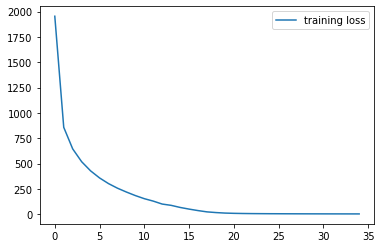

Test accuracy is: 99.17 %


In [13]:

plt.plot(losses, label='training loss')
plt.legend()
plt.show()
acc = DigitLearner.accuracy(test.predict(X_test), Y_test)

print("Test accuracy is:",acc*100,"%")